### FINAL PREDICTIVE ANALYTICS MODEL (DECISION TREE) FOR SHELTER CAT ADOPTION AND TRANSFER OUTCOMES <br> Tess Anderson | DS-450 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA 

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion

import warnings
warnings.simplefilter('ignore')

#### PREPARING THE DATA

In [3]:
cat_outcomes = pd.read_csv('aac_shelter_cat_outcome_eng.csv')

In [4]:
# according to Austin Animal Center, adoptions and transfers to partner facilities represent over 90% of all outcomes.
# so, I use .loc method to filter the dataset for only those values. 
cat_outcomes = cat_outcomes.loc[(cat_outcomes['outcome_type'] == 'Adoption') |
                                (cat_outcomes['outcome_type'] == 'Transfer')]

In [5]:
# to look deeper into these outcomes, we overwrite the outcome type with the subtype, which is slightly more detailed.
cat_outcomes['outcome_subtype'] = np.where(pd.isnull(cat_outcomes['outcome_subtype']),
                                           cat_outcomes['outcome_type'],
                                           cat_outcomes['outcome_subtype'])

In [6]:
cat_outcomes['outcome_subtype'].value_counts()

outcome_subtype
Partner     9486
Adoption    9264
Foster      3357
SCRP        3211
Snr          625
Offsite      110
Barn           2
Name: count, dtype: int64

In [7]:
# during exploratory phase, we found several categorical variables that seemed to have an impact on the outcome.
# we filter the dataset using the filter method to include the columns of interest
x = cat_outcomes.filter(items=['sex_upon_outcome', 'breed', 'color', 'coat_pattern',
                               'domestic_breed', 'dob_month', 'age_group', 'outcome_month',
                               'outcome_weekday', 'outcome_hour', 'Cat/Kitten (outcome)'])

In [8]:
# next, we conver these columns to categorical data type so they can be transformed into numerical representations later to prepare for the model. 
for col in x:
    x[col] = x[col].astype('category')

y = cat_outcomes['outcome_subtype'].astype('category')

In [9]:
# now, we can encode the categorical variables as dummy variables.
xd = pd.get_dummies(x)

In [10]:
# keeping the names of the columns in a list for plotting later and creating an array
xnames = xd.columns
xarr = np.array(xd)

In [11]:
# using pandas factorize function to create a numerical representation of the outcomes for scikit-learn ML methods format
yarr, ynames = pd.factorize(cat_outcomes['outcome_subtype'])

In [12]:
# now, we split the data for analysis
x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.2, random_state=42)

In [13]:
# using a scaler to center and scale the X data to meet assumptions made by sklearn's ML algorithms
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#### FINDING IMPORTANT FEATURES WITH DECISION TREE

In [14]:
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

<Axes: xlabel='feature', ylabel='importance'>

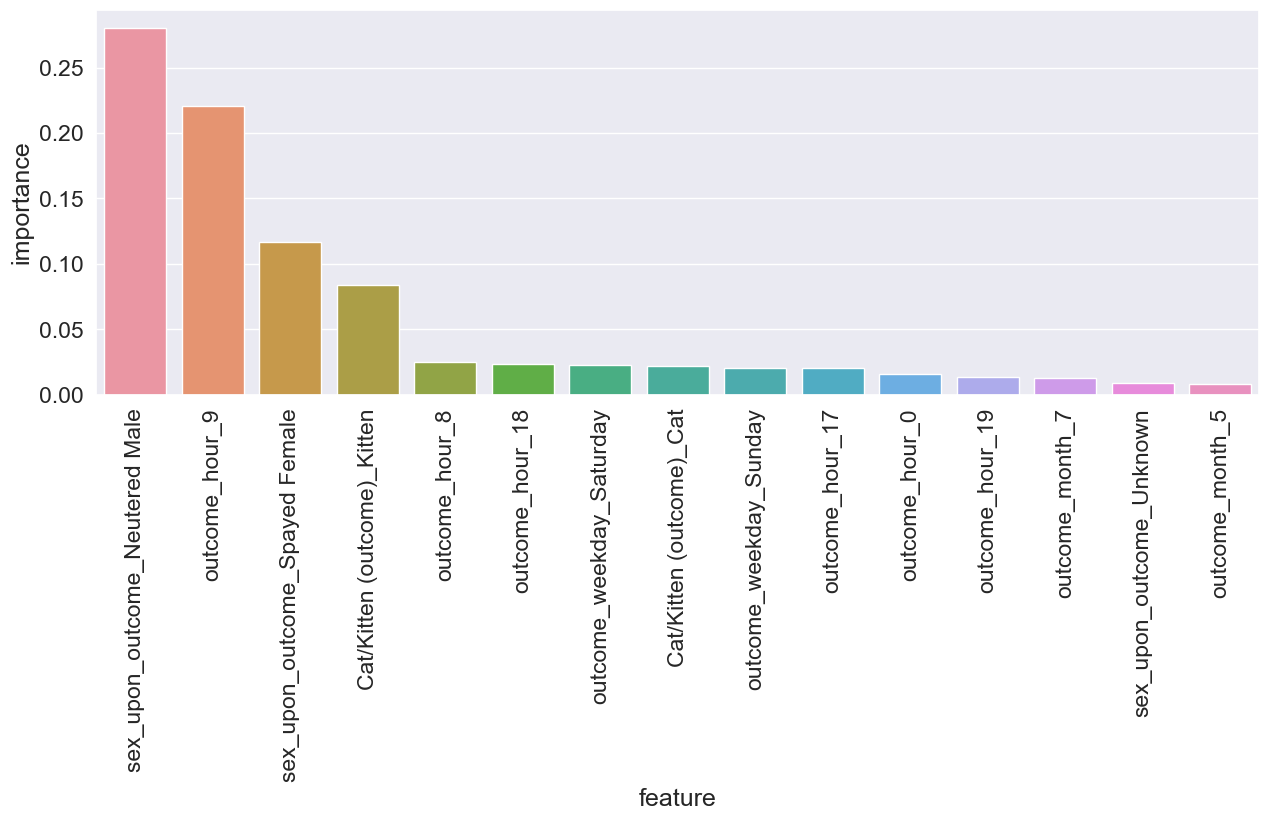

In [15]:
# with the model fit, we can extract the feature improtances into a dataframe and plot the top 15 most important
feature_importances = dt_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames},
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

##### The decision tree classifier reports the most important features are:
* The spay/neuter status and sex of the cats are high ranking features
* The time of outcome is significantly important with the highest ones being 9 am, 8 am, and 6 pm.
* Weekday is important, weekends are shown as most important of the weekdays.

#### DIMENSION REDUCTION WITH PCA

In [16]:
# dimension reduction reduces the dimesionality into a lower dimensiaonal space which allows input data to be reduced while still keeping the same amount of information. 
# this will help with run times during model fitting and cross validation.
pca = PCA()
pca.fit(x_train_scaled)

PCA()

#### BUILDING THE ADOPTION AND TRANSFER PREDICTION MODEL

In [60]:
# to train and test the model, we use sklearn's Pipeline to chain multiple preprocessing steps.
# FeatureUnion is used to transform the data and concatenate the results for use with the Pipeline model.
# PCA is used as explained above, as well as SelectKBest to further reduce the amount of data while still retaining the most useful features.

feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('clf', DecisionTreeClassifier(max_depth=20, random_state=42))
])

In [61]:
prediction_model.fit(x_train_scaled, y_train)

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('pca', PCA()),
                                                ('kbest', SelectKBest())])),
                ('clf', DecisionTreeClassifier(max_depth=20, random_state=42))])

#### PREDICTION MODEL ACCURACY AND CROSS-VALIDATION

In [62]:
# cross validation helps check and verify how the model could potentially perform with new data - this is important as we are interested in the implications of this analysis, not only for this dataset and shelter but for other shelters across the nation.
# cross validation splits the data into smaller subsets and fits the model on these, then validates the model on the remaining data and averages the results into a score.
cv = StratifiedKFold(2)
# we set the number of folds to 2 because the StratifiedKFold procedure splits data by class labels and the Barn class only has two cases

In [63]:
# the cv score is the cross validation score as explained above - there are 2 in the array because the number of folds is 2.
# cv predict score is the score for cross-validated predictions made against the subsetted data and is used to generate an accuracy score for predictions when compared with the true y values in the dataset. 
cv_score = cross_val_score(prediction_model, x_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train_scaled, y_train, cv=cv)

In [64]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))

[0.6433506  0.64392631]
0.6436384571099597
0.6436384571099597


In [65]:
# we further test the model performance by using the test data from the orginal test train split.
dt_pred = prediction_model.predict(x_test_scaled)

In [66]:
print(accuracy_score(y_test, dt_pred))
# this score reports the accuracy of the predicted y values against the true y values - around 74% accuracy.

0.6724237190558434


In [67]:
def append_row(df, row):
    return pd.concat([
        df,
        pd.DataFrame([row], columns=row.index)]
        ).reset_index(drop=True)

df = pd.DataFrame(columns=('model', 'specs', 'accuracy'))

In [68]:
new_row = pd.Series({'model':'Decision Tree', 'specs':'max_len=3', 'accuracy':'0.6194'})
df = append_row(df, new_row)

In [69]:
new_row = pd.Series({'model':'Decision Tree', 'specs':'max_len=5', 'accuracy':'0.6786'})
df = append_row(df, new_row)

In [70]:
new_row = pd.Series({'model':'Decision Tree', 'specs':'max_len=10', 'accuracy':'0.6969'})
df = append_row(df, new_row)

In [71]:
new_row = pd.Series({'model':'Decision Tree', 'specs':'max_len=15', 'accuracy':'0.6885'})
df = append_row(df, new_row)

In [72]:
new_row = pd.Series({'model':'Decision Tree', 'specs':'max_len=20', 'accuracy':'0.6724'})
df = append_row(df, new_row)

In [73]:
df.head()

,model,specs,accuracy
0,Decision Tree,max_len=3,0.6194
1,Decision Tree,max_len=5,0.6786
2,Decision Tree,max_len=10,0.6969
3,Decision Tree,max_len=15,0.6885
4,Decision Tree,max_len=20,0.6724


In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
Confusion matrix, without normalization


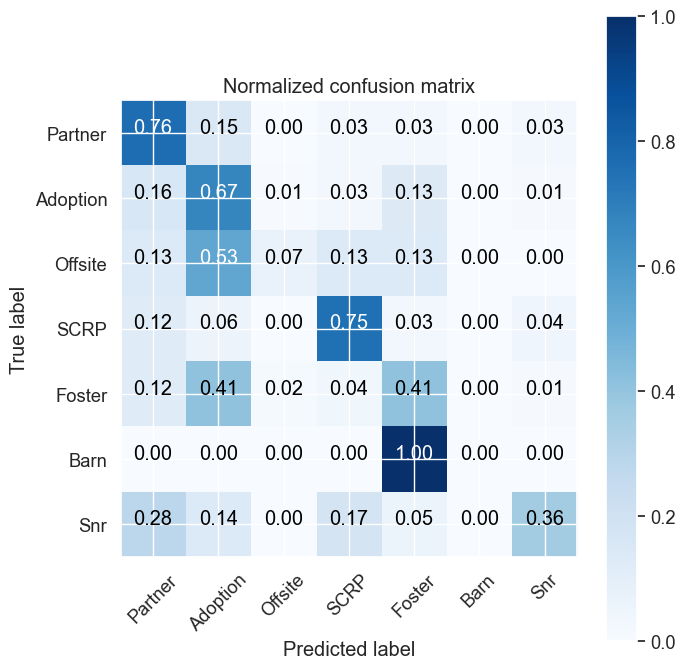

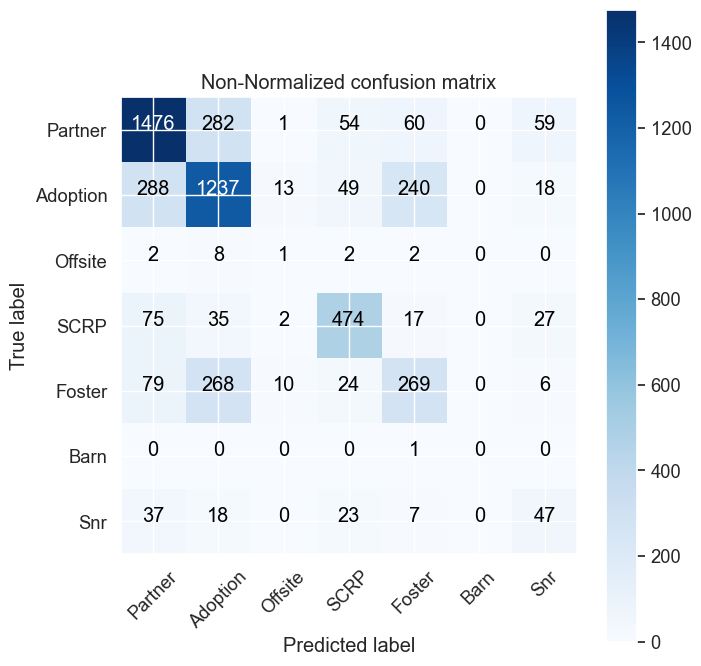

In [75]:
sns.set(font_scale=1.2)

rf_cnf_mat = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=True, title='Normalized confusion matrix')

plt.figure(figsize=(7, 7))
plot_confusion_matrix(rf_cnf_mat, classes=ynames, normalize=False, title='Non-Normalized confusion matrix')

plt.show()

In [76]:
print(classification_report(y_test, rf_pred, target_names=ynames))

              precision    recall  f1-score   support

     Partner       0.75      0.76      0.76      1932
    Adoption       0.67      0.67      0.67      1845
     Offsite       0.04      0.07      0.05        15
        SCRP       0.76      0.75      0.75       630
      Foster       0.45      0.41      0.43       656
        Barn       0.00      0.00      0.00         1
         Snr       0.30      0.36      0.33       132

    accuracy                           0.67      5211
   macro avg       0.42      0.43      0.43      5211
weighted avg       0.67      0.67      0.67      5211



##### The confusion matrices report the following:
* The best model used max length 10 and generated an accuracy score of 0.6969
* The model was most successful in predicting adoption and transfer outcomes - this makes sense as these categories had the highest n (number of samples)
* SCRP and fostering were also predicted decently, however it shows significant misclassification between foster and adoption outcomes.

In [77]:
df.to_csv('DTmodels.csv', index=False)